# Performance optimization

This notebook examine which settings is optimal regard time consuption when training neural networks using keras. All the test will be used on the fully connected neural network on the full dataset (all 8 classes). The following will be tested:
 <div class="alert alert-block alert-warning">
    <b>Performance optimization</b> 
    <ol>
        <li>Difference between self made mean subtracting method versus imagedatagenerator feature_wise mean method, to centralizing the dataset.</li>
        <li>Numbers of workers versus cores in fit generator<ul>
            <li>Testing for a quad core 8 thread processor</li>
        </ul>
        <li>Loading dataset into ram versus not loading into ram</li> 
    </ol>
    
</div>

**Includes**

In [2]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.layers import Dense, Activation, Flatten
from keras.models import Model, Sequential
from keras import models
from keras import layers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from util.plots import plot_history
from glob import glob
import util.image_import as ii
from util.data_generator import make_data_generator
import os
from keras.utils.np_utils import to_categorical
from nets.feedforward.fcn_net import fcn_net
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
cfg = K.tf.ConfigProto() # Config to dynamically add memory
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))# set this TensorFlow session as the default session for Keras.

In [4]:
num_classes = 8
batch_size = 32
train_path = '../dataset3/res_still/train'
test_path = '../dataset3/res_still/test'

## 1: Difference in Keras setting ImageDataGenerator featurewise_center versus self made method to calculate mean picture 

In [3]:
train_path = '../dataset3/res_still/train'
X_train, y_train = ii.images_to_numpy_full_class(train_path)
print("Self made "+str(ii.calulate_mean(train_path).shape))
print("Keras featurewice "+str(ii.calculate_mean_keras(X_train).shape))

Self made (224, 224, 3)
Keras featurewice (1, 1, 3)


As it can be seen from the above results, the self made method gives a whole picture where each pixel has been meaned for every pixel seperatly and the channels kept. 
For the keras method each pixel has been meaned together but with the channels kept.

Thus the keras method is missing information and may be as precise as the self made method.<br> 
### The two different mean method is tested below: 

In [5]:
# All loaded into ram
X_train, y_train = ii.images_to_numpy_full_class(train_path)
X_test, y_test = ii.images_to_numpy_full_class(test_path)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

**Self made method generators:**

In [6]:
mean_image_train = ii.calulate_mean(train_path) # Calculates mean for each channel for every pixel
def subtract_mean(img):
    return img - mean_image_train
    
train_datagen_self = ImageDataGenerator(
                      rescale=1./255,
                      rotation_range=10,
                      vertical_flip=True,
                      horizontal_flip=True,
                      brightness_range=(0.65, 1.35),
                      preprocessing_function=subtract_mean)

test_datagen_self = ImageDataGenerator( 
                     rescale=1./255,
                     preprocessing_function=subtract_mean)


train_datagen_self = train_datagen_self.flow(X_train,
                                             y_train,
                                             batch_size=batch_size, shuffle=True)

test_datagen_self = test_datagen_self.flow(X_test,
                                           y_test,
                                           batch_size=batch_size, shuffle=True)

print("Found Training " + str(X_train.shape[0]) + " images belonging to " + str(num_classes) + " classes")
print("Found Test " + str(X_test.shape[0]) + " images belonging to " + str(num_classes) + " classes")    

Found Training 1875 images belonging to 8 classes
Found Test 472 images belonging to 8 classes


**Keras featurewise center method generators:**

In [7]:
train_datagen_keras = ImageDataGenerator(
                      featurewise_center=True,
                      rescale=1./255,
                      rotation_range=10,
                      vertical_flip=True,
                      horizontal_flip=True,
                      brightness_range=(0.65, 1.35))

test_datagen_keras = ImageDataGenerator(
                     featurewise_center=True, 
                     rescale=1./255)


# Required for featurewise normalization
train_datagen_keras.fit(X_train/255.)
test_datagen_keras.fit(X_train/255.)

train_datagen_keras = train_datagen_keras.flow(X_train,
                                               y_train,
                                               batch_size=batch_size, shuffle=True)

test_datagen_keras = test_datagen_keras.flow(X_test,
                                             y_test,
                                             batch_size=batch_size, shuffle=True)

print("Found Training " + str(X_train.shape[0]) + " images belonging to " + str(num_classes) + " classes")
print("Found Test " + str(X_test.shape[0]) + " images belonging to " + str(num_classes) + " classes")    

Found Training 1875 images belonging to 8 classes
Found Test 472 images belonging to 8 classes


**Training both for 100 epoch**

In [9]:
model = fcn_net() # Gets the model
history_self      = model.fit_generator(
                    train_datagen_self,
                    steps_per_epoch=1875 // batch_size,
                    epochs=100,
                    validation_data=test_datagen_self,
                    validation_steps=472 // batch_size,
                    use_multiprocessing=True,
                    workers=2)
model = fcn_net() # rewrite model again
history_keras     = model.fit_generator(
                    train_datagen_keras,
                    steps_per_epoch=1875 // batch_size,
                    epochs=100,
                    validation_data=test_datagen_keras,
                    validation_steps=472 // batch_size,
                    use_multiprocessing=True,
                    workers=2)

Epoch 1/100
58/58 [==============================] - 12s 199ms/step - loss: 3.2718 - acc: 0.1784 - val_loss: 1.6815 - val_acc: 0.3438
Epoch 2/100
58/58 [==============================] - 11s 195ms/step - loss: 2.5356 - acc: 0.2542 - val_loss: 1.5283 - val_acc: 0.4621
Epoch 3/100
58/58 [==============================] - 12s 208ms/step - loss: 2.3176 - acc: 0.2756 - val_loss: 1.3956 - val_acc: 0.5045
Epoch 4/100
58/58 [==============================] - 11s 192ms/step - loss: 2.0641 - acc: 0.3190 - val_loss: 1.2894 - val_acc: 0.4955
Epoch 5/100
58/58 [==============================] - 12s 210ms/step - loss: 2.0161 - acc: 0.3555 - val_loss: 1.2135 - val_acc: 0.5469
Epoch 6/100
58/58 [==============================] - 11s 198ms/step - loss: 1.9435 - acc: 0.3803 - val_loss: 1.1157 - val_acc: 0.5670
Epoch 7/100
58/58 [==============================] - 12s 203ms/step - loss: 1.7111 - acc: 0.4149 - val_loss: 1.1897 - val_acc: 0.5625
Epoch 8/100
58/58 [==============================] - 12s 211ms

Epoch 62/100
58/58 [==============================] - 13s 229ms/step - loss: 0.9779 - acc: 0.7370 - val_loss: 0.7491 - val_acc: 0.8103
Epoch 63/100
58/58 [==============================] - 14s 239ms/step - loss: 0.8655 - acc: 0.7349 - val_loss: 0.6676 - val_acc: 0.8125
Epoch 64/100
58/58 [==============================] - 13s 232ms/step - loss: 0.7658 - acc: 0.7406 - val_loss: 0.6428 - val_acc: 0.8304
Epoch 65/100
58/58 [==============================] - 14s 239ms/step - loss: 0.8579 - acc: 0.7316 - val_loss: 0.7572 - val_acc: 0.8058
Epoch 66/100
58/58 [==============================] - 14s 245ms/step - loss: 0.6906 - acc: 0.7672 - val_loss: 0.6939 - val_acc: 0.8147
Epoch 67/100
58/58 [==============================] - 15s 251ms/step - loss: 0.8961 - acc: 0.7587 - val_loss: 0.6540 - val_acc: 0.8482
Epoch 68/100
58/58 [==============================] - 14s 241ms/step - loss: 0.7540 - acc: 0.7577 - val_loss: 0.7161 - val_acc: 0.8036
Epoch 69/100
58/58 [==============================] - 1

58/58 [==============================] - 15s 255ms/step - loss: 5.5898 - acc: 0.2774 - val_loss: 5.7115 - val_acc: 0.2143
Epoch 23/100
58/58 [==============================] - 14s 233ms/step - loss: 5.3717 - acc: 0.2990 - val_loss: 5.3102 - val_acc: 0.3527
Epoch 24/100
58/58 [==============================] - 14s 235ms/step - loss: 5.5788 - acc: 0.2985 - val_loss: 5.3520 - val_acc: 0.2656
Epoch 25/100
58/58 [==============================] - 15s 256ms/step - loss: 5.3483 - acc: 0.3036 - val_loss: 5.5210 - val_acc: 0.3482
Epoch 26/100
58/58 [==============================] - 15s 260ms/step - loss: 5.6308 - acc: 0.2944 - val_loss: 5.5472 - val_acc: 0.2835
Epoch 27/100
58/58 [==============================] - 14s 243ms/step - loss: 5.6175 - acc: 0.3040 - val_loss: 5.8298 - val_acc: 0.2478
Epoch 28/100
58/58 [==============================] - 14s 245ms/step - loss: 5.3302 - acc: 0.3260 - val_loss: 5.4454 - val_acc: 0.2478
Epoch 29/100
58/58 [==============================] - 16s 271ms/step

Epoch 83/100
58/58 [==============================] - 13s 224ms/step - loss: 1.9402 - acc: 0.1811 - val_loss: 1.9424 - val_acc: 0.1317
Epoch 84/100
58/58 [==============================] - 13s 224ms/step - loss: 1.9447 - acc: 0.1940 - val_loss: 1.9463 - val_acc: 0.2411
Epoch 85/100
58/58 [==============================] - 13s 219ms/step - loss: 1.9364 - acc: 0.2015 - val_loss: 1.9322 - val_acc: 0.1339
Epoch 86/100
58/58 [==============================] - 13s 226ms/step - loss: 1.9256 - acc: 0.1865 - val_loss: 1.9111 - val_acc: 0.2188
Epoch 87/100
58/58 [==============================] - 14s 235ms/step - loss: 1.9220 - acc: 0.1816 - val_loss: 1.9075 - val_acc: 0.1696
Epoch 88/100
58/58 [==============================] - 16s 268ms/step - loss: 1.9170 - acc: 0.1945 - val_loss: 1.9253 - val_acc: 0.2143
Epoch 89/100
58/58 [==============================] - 13s 219ms/step - loss: 1.9376 - acc: 0.1958 - val_loss: 1.9107 - val_acc: 0.1585
Epoch 90/100
58/58 [==============================] - 1

_______________________Keras featurewise_center_______________________
Last: Training accuracy 0.19099294638025716 Validation accuracy 0.15625


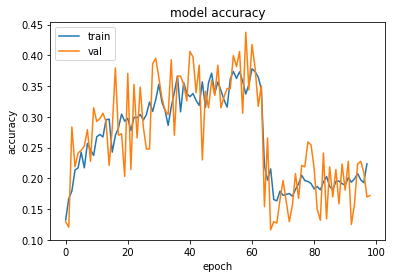

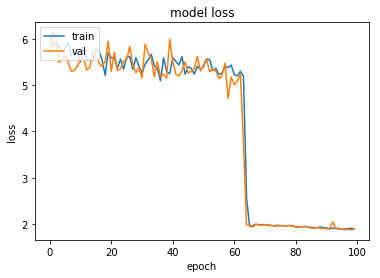

___________________________Self made method___________________________
Last: Training accuracy 0.8231144873137327 Validation accuracy 0.8638392857142857


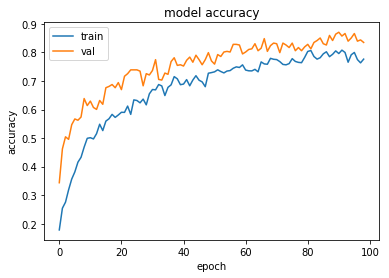

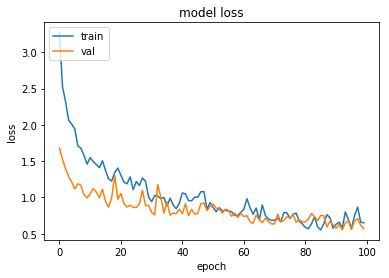

In [14]:
print("_______________________Keras featurewise_center_______________________")
print("Last: Training accuracy " + str(history_keras.history['acc'].pop()) + " Validation accuracy " + str(history_keras.history['val_acc'].pop()))
plot_history(history_keras)
print("___________________________Self made method___________________________")
print("Last: Training accuracy " + str(history_self.history['acc'].pop()) + " Validation accuracy " + str(history_self.history['val_acc'].pop()))
plot_history(history_self)

#### Conclusion
From the above graphs and training- and validation- accuracy is it clear the self made method is the best method for the fully connected network thus this method is chosen to be used.
<span style="color:red"> Mangler måske lidt forklaring hvorfor vores er bedre</span>

## 2: How many workers is optimal for a quad core processor

<span style="color:red"> Forklar hvad en worker er størrelse af train og batch size osv. </span>
Numbers of worker tested is 0-7 

In [28]:
train_generators_list = []
test_generators_list = []
ram_not_ram = ["Into ram", "Not into ram"]
train_generator_ram, test_generator_ram = make_data_generator(train_path, test_path, val_path="", load_ram=True)
train_generator_not_ram, test_generator_not_ram = make_data_generator(train_path, test_path, val_path="", load_ram=False)

# Append to list
train_generators_list.append(train_generator_ram)
train_generators_list.append(train_generator_not_ram)
test_generators_list.append(test_generator_ram)
test_generators_list.append(test_generator_not_ram)

Found Training 1875 images belonging to 8 classes
Found Test 472 images belonging to 8 classes
Found 1875 images belonging to 8 classes.
Found 472 images belonging to 8 classes.


In [46]:
num_workers = 8
for w in range(num_workers):
    for i, generator in enumerate(train_generators_list):
        # GPU memory allocation
        cfg = K.tf.ConfigProto() # Create setup file for keras tensorflow
        cfg.gpu_options.allow_growth = True # Setting setup file with dynamically adding gpu memory
        K.set_session(K.tf.Session(config=cfg)) # Setting session to use setup file
        sess = tf.Session() 
        K.set_session(sess)# set this TensorFlow session as the default session for Keras.

        # Defining the model:
        model = fcn_net()
        # Running the model:
        print("________Number of Workers: " + str(w)+ ", Loaded " + str(ram_not_ram[i]) + "_______________________")
        model.fit_generator(
                generator,
                steps_per_epoch=1875 // batch_size,
                epochs=1,
                validation_data=test_generators_list[i],
                validation_steps=472 // batch_size,
                verbose=2,
                use_multiprocessing=True,
                workers=w)
        del model
        K.clear_session() # Clearing the session to clear out gpu memory

    

________Number of Workers: 0, Loaded Into ram_______________________
Epoch 1/1
 - 19s - loss: 3.1127 - acc: 0.1893 - val_loss: 1.6934 - val_acc: 0.3636
________Number of Workers: 0, Loaded Not into ram_______________________
Epoch 1/1
 - 38s - loss: 2.9258 - acc: 0.2130 - val_loss: 1.6805 - val_acc: 0.3929
________Number of Workers: 1, Loaded Into ram_______________________
Epoch 1/1
 - 21s - loss: 2.9680 - acc: 0.1784 - val_loss: 1.7157 - val_acc: 0.3795
________Number of Workers: 1, Loaded Not into ram_______________________
Epoch 1/1
 - 42s - loss: 3.0025 - acc: 0.1996 - val_loss: 1.5775 - val_acc: 0.4129
________Number of Workers: 2, Loaded Into ram_______________________
Epoch 1/1
 - 13s - loss: 2.9991 - acc: 0.2152 - val_loss: 1.7428 - val_acc: 0.4241
________Number of Workers: 2, Loaded Not into ram_______________________
Epoch 1/1
 - 25s - loss: 2.8498 - acc: 0.2041 - val_loss: 1.6868 - val_acc: 0.3795
________Number of Workers: 3, Loaded Into ram_______________________
Epoch 1


## 3: Time difference in loading whole dataset into ram versus not loading whole dataset into ram 

### Checking loaded into ram versus not is the same within margin of error by running both for 100 epoch

In [49]:
history = []
result = None
results = []
for i, generator in enumerate(train_generators_list):
    # GPU memory allocation
    cfg = K.tf.ConfigProto() # Create setup file for keras tensorflow
    cfg.gpu_options.allow_growth = True # Setting setup file with dynamically adding gpu memory
    K.set_session(K.tf.Session(config=cfg)) # Setting session to use setup file
    sess = tf.Session() 
    K.set_session(sess)# set this TensorFlow session as the default session for Keras.

    # Defining the model:
    model = fcn_net()
    # Running the model:
    print("________________Loaded " + str(ram_not_ram[i]) + "_______________________")
    temp = model.fit_generator(
            generator,
            steps_per_epoch=1875 // batch_size,
            epochs=100,
            validation_data=test_generators_list[i],
            validation_steps=472 // batch_size,
            use_multiprocessing=True,
            workers=2)
    
    # Saving the results
    history.append(temp)
    train_acc = temp.history['acc'].pop()
    val_acc = temp.history['val_acc'].pop()
    result = (train_acc, val_acc)
    results.append(result)
    
    del model
    K.clear_session() # Clearing the session to clear out gpu memory

________________Loaded Into ram_______________________
Epoch 1/100
58/58 [==============================] - 12s 208ms/step - loss: 3.4269 - acc: 0.1550 - val_loss: 1.7813 - val_acc: 0.3772
Epoch 2/100
58/58 [==============================] - 13s 217ms/step - loss: 2.3574 - acc: 0.2301 - val_loss: 1.5078 - val_acc: 0.4241
Epoch 3/100
58/58 [==============================] - 13s 224ms/step - loss: 2.2961 - acc: 0.2926 - val_loss: 1.3982 - val_acc: 0.5156
Epoch 4/100
58/58 [==============================] - 13s 228ms/step - loss: 2.2000 - acc: 0.3248 - val_loss: 1.3711 - val_acc: 0.5089
Epoch 5/100
58/58 [==============================] - 12s 215ms/step - loss: 2.0415 - acc: 0.3639 - val_loss: 1.4622 - val_acc: 0.5446
Epoch 6/100
58/58 [==============================] - 12s 215ms/step - loss: 1.9216 - acc: 0.3955 - val_loss: 1.3020 - val_acc: 0.5469
Epoch 7/100
58/58 [==============================] - 14s 234ms/step - loss: 1.8430 - acc: 0.4097 - val_loss: 1.2900 - val_acc: 0.5647
Epoch 8

58/58 [==============================] - 13s 221ms/step - loss: 0.7059 - acc: 0.7658 - val_loss: 0.7067 - val_acc: 0.8125
Epoch 62/100
58/58 [==============================] - 14s 242ms/step - loss: 0.7193 - acc: 0.7760 - val_loss: 0.7498 - val_acc: 0.8036
Epoch 63/100
58/58 [==============================] - 13s 220ms/step - loss: 0.6746 - acc: 0.7760 - val_loss: 0.6931 - val_acc: 0.8170
Epoch 64/100
58/58 [==============================] - 13s 229ms/step - loss: 0.7791 - acc: 0.7541 - val_loss: 0.7112 - val_acc: 0.8147
Epoch 65/100
58/58 [==============================] - 13s 226ms/step - loss: 0.8529 - acc: 0.7624 - val_loss: 0.6892 - val_acc: 0.8170
Epoch 66/100
58/58 [==============================] - 14s 247ms/step - loss: 0.7723 - acc: 0.7516 - val_loss: 0.6642 - val_acc: 0.8348
Epoch 67/100
58/58 [==============================] - 16s 276ms/step - loss: 0.7614 - acc: 0.7519 - val_loss: 0.8009 - val_acc: 0.8013
Epoch 68/100
58/58 [==============================] - 15s 263ms/step

Epoch 21/100
58/58 [==============================] - 25s 440ms/step - loss: 1.1471 - acc: 0.6120 - val_loss: 1.0326 - val_acc: 0.6808
Epoch 22/100
58/58 [==============================] - 26s 443ms/step - loss: 1.1102 - acc: 0.6376 - val_loss: 1.0398 - val_acc: 0.6451
Epoch 23/100
58/58 [==============================] - 27s 468ms/step - loss: 1.0761 - acc: 0.6315 - val_loss: 1.1491 - val_acc: 0.6183
Epoch 24/100
58/58 [==============================] - 29s 494ms/step - loss: 1.0698 - acc: 0.6161 - val_loss: 1.0088 - val_acc: 0.6674
Epoch 25/100
58/58 [==============================] - 30s 521ms/step - loss: 1.0331 - acc: 0.6344 - val_loss: 0.8818 - val_acc: 0.6897
Epoch 26/100
58/58 [==============================] - 26s 450ms/step - loss: 1.0973 - acc: 0.6508 - val_loss: 0.8221 - val_acc: 0.7076
Epoch 27/100
58/58 [==============================] - 29s 507ms/step - loss: 1.0587 - acc: 0.6562 - val_loss: 0.7701 - val_acc: 0.7254
Epoch 28/100
58/58 [==============================] - 2

Epoch 82/100
58/58 [==============================] - 27s 460ms/step - loss: 0.7329 - acc: 0.7841 - val_loss: 0.6660 - val_acc: 0.8170
Epoch 83/100
58/58 [==============================] - 28s 474ms/step - loss: 0.7171 - acc: 0.7721 - val_loss: 0.5572 - val_acc: 0.8594
Epoch 84/100
58/58 [==============================] - 27s 472ms/step - loss: 0.6378 - acc: 0.7722 - val_loss: 0.6214 - val_acc: 0.8594
Epoch 85/100
58/58 [==============================] - 26s 452ms/step - loss: 0.5934 - acc: 0.7977 - val_loss: 0.6153 - val_acc: 0.8460
Epoch 86/100
58/58 [==============================] - 28s 479ms/step - loss: 0.6012 - acc: 0.7926 - val_loss: 0.5918 - val_acc: 0.8415
Epoch 87/100
58/58 [==============================] - 27s 460ms/step - loss: 0.8238 - acc: 0.7596 - val_loss: 0.5936 - val_acc: 0.8571
Epoch 88/100
58/58 [==============================] - 28s 483ms/step - loss: 0.5778 - acc: 0.7979 - val_loss: 0.6671 - val_acc: 0.8504
Epoch 89/100
58/58 [==============================] - 2

In [57]:
for i, r in enumerate(results):
    print("________________Loaded " + str(ram_not_ram[i]) + "_______________________")
    print('train accuracy: %f val accuracy: %f' % r)         

________________Loaded Into ram_______________________
train accuracy: 0.809007 val accuracy: 0.821429
________________Loaded Not into ram_______________________
train accuracy: 0.792729 val accuracy: 0.843750
